This notebook illustrates running the deAlmeida overland flow component in an extremely simple-minded way on a real topography, then shows it creating a flood sequence along an inclined surface with an oscillating water surface at one end.

First, import what we'll need:

In [36]:
from __future__ import print_function

from landlab.components.overland_flow import OverlandFlow
from landlab.grid.structured_quad import links
from landlab.plot.imshow import imshow_node_grid
from landlab import RasterModelGrid
from landlab.io.esri_ascii import read_esri_ascii
from matplotlib.pyplot import figure, show
import numpy as np
from time import time
%matplotlib inline

Pick the initial and run conditions

In [37]:
run_time = 100           # duration of run, (s)
h_init = 0.1            # initial thin layer of water (m)
n = 0.01                  # roughness coefficient, (s/m^(1/3))
g = 9.8                   # gravity (m/s^2)
alpha = 0.7               # time-step factor (nondimensional; from Bates et al., 2010)
u = 0.4                   # constant velocity (m/s, de Almeida et al., 2012)
run_time_slices = (10,50,100,200)

Elapsed time starts at 1 second. This prevents errors when setting our boundary conditions.

In [38]:
elapsed_time = 1.0

Use LL methods to import an ARC ascii grid, and load the data into the field that the component needs to look at to get the data. This loads the elevation data, z, into a "field" in the grid itself, defined on the nodes.

In [39]:
rmg, z = read_esri_ascii('HalfFork.asc')
rmg.add_field('node', 'topographic__elevation', z)
rmg.set_nodata_nodes_to_closed(z, -9999.)

We can get at this data with this syntax:

In [40]:
np.all(rmg.at_node['topographic__elevation'] == z)

True

Note that the boundary conditions for this grid mainly got handled with the final line of those three, but for completeness' sake, we should probably manually "open" the outlet. We can find and set it like this:

In [41]:
core_node_order = np.argmin(z[rmg.core_nodes])
my_outlet_node = rmg.core_nodes[core_node_order]
rmg.status_at_node[my_outlet_node] = 1  # 1 is the code for fixed value

Now initialize a couple more grid fields that the component is going to need:

In [42]:
rmg.create_node_array_zeros('water_depth')                   # water depth (m)
rmg.add_zeros('active_link', 'water_discharge')              # unit discharge (m2/s)

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [43]:
rmg.at_node['water_depth'] += h_init

Now instantiate the component itself

In [44]:
of = OverlandFlow(rmg)

Now we're going to run the loop that drives the component:

In [45]:
while elapsed_time < run_time:
    # First, we calculate our time step.
    dt = of.gear_time_step(rmg)
    print(dt)
    # Now, we can generate overland flow.
    of.overland_flow(rmg, dt)
    # Increased elapsed time
    elapsed_time += dt

3.51798772365
2.59853359352
2.11617582488
1.77638202436
1.55019634343
1.36664014988
1.2671948234
1.21207662896
1.13378116189
1.06926291759
1.0086206061
0.970592376396
0.952012008752
0.934325243156
0.906403426263
0.900221713187
0.885252525407
0.859152001377
0.839056868847
0.826595825871
0.822093656868
0.816328074379
0.80163560682
0.795886571917
0.793475029387
0.7909947803
0.789241401075
0.788859594904
0.78749800978
0.782058011902
0.772807546539
0.763513929877
0.757207941093
0.753932730866
0.752051953394
0.750177124341
0.747754786068
0.744683496759
0.741144071423
0.73766005007
0.73479624677
0.732695810872
0.731023231242
0.729619343443
0.728413348661
0.727785178693
0.727119085706
0.726078948823
0.724771637262
0.723578749026
0.722599434126
0.719964827742
0.716691281553
0.713295307654
0.710438004998
0.707651176437
0.705321480622
0.702701029426
0.700687945921
0.698665918868
0.695566646525
0.689649083102
0.689235702283
0.689452361555
0.687064896106
0.684209690899
0.682683176718
0.681388715222

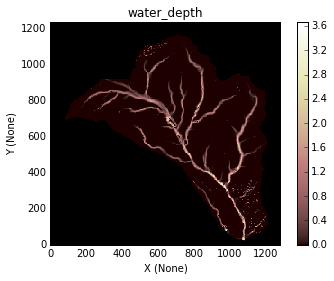

In [46]:
imshow_node_grid(rmg, 'water_depth')

Now let's get clever, and run a set of time slices:

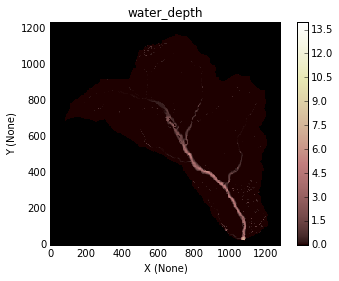

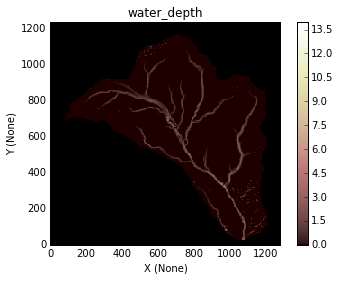

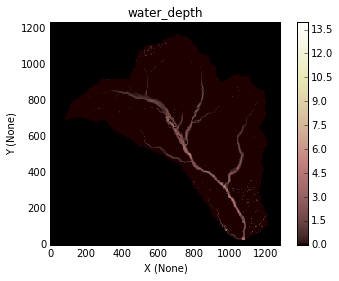

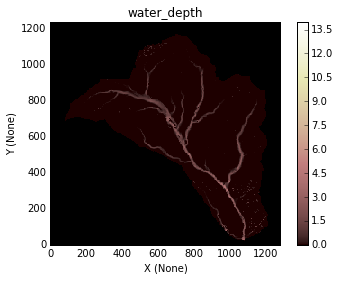

In [47]:
elapsed_time = 1.
for t in run_time_slices:
    while elapsed_time < t:
        # First, we calculate our time step.
        dt = of.gear_time_step(rmg)
        # Now, we can generate overland flow.
        of.overland_flow(rmg, dt)
        # Increased elapsed time
        elapsed_time += dt
    figure(t)
    imshow_node_grid(rmg, 'water_depth', vmax=14.)